In [1]:
import numpy as np
import tensorflow as tf
#import tensorflow.keras as keras
import matplotlib.pyplot as plt
import os

In [2]:
tf.test.gpu_device_name()

''

In [3]:
classes = np.array(["air_conditioner","car_horn","children_playing","dog_bark","drilling","engine_idling","gun_shot","jackhammer","siren","street_music"])

In [4]:
dataset_path = "/mnt/3206BFFF191E7F85/UrbanSound8K/audio/"
train_files = []
for fold in os.listdir(dataset_path)[1:]:
  files = os.listdir(os.path.join(dataset_path, fold))
  for i,f in enumerate(files):
    files[i] = dataset_path+fold+"/"+f
  train_files.extend(files)

In [5]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary, desired_channels=1)
  return tf.squeeze(audio, axis=-1)

In [6]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)

  # Note: You'll use indexing here instead of tuple unpacking to enable this
  # to work in a TensorFlow graph.
  return parts[-2]


In [9]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  audio_binary = tf.dtypes.cast(audio_binary, tf.int32)
  waveform = decode_audio(audio_binary)
  return waveform, label


In [10]:
AUTOTUNE = -1
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

TypeError: in user code:

    <ipython-input-9-edd2f63584bd>:5 get_waveform_and_label  *
        waveform = decode_audio(audio_binary)
    <ipython-input-5-d81df4fe8c28>:2 decode_audio  *
        audio, _ = tf.audio.decode_wav(audio_binary, desired_channels=1)
    /home/andrea/.local/lib/python3.6/site-packages/tensorflow/python/ops/gen_audio_ops.py:207 decode_wav  **
        desired_samples=desired_samples, name=name)
    /home/andrea/.local/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:493 _apply_op_helper
        (prefix, dtypes.as_dtype(input_arg.type).name))

    TypeError: Input 'contents' of 'DecodeWav' Op has type int32 that does not match expected type of string.


In [91]:
def get_spectrogram(waveform):
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([320000] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)

  spectrogram = tf.abs(spectrogram)

  return spectrogram

/home/andrea/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/home/andrea/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  if __name__ == '__main__':


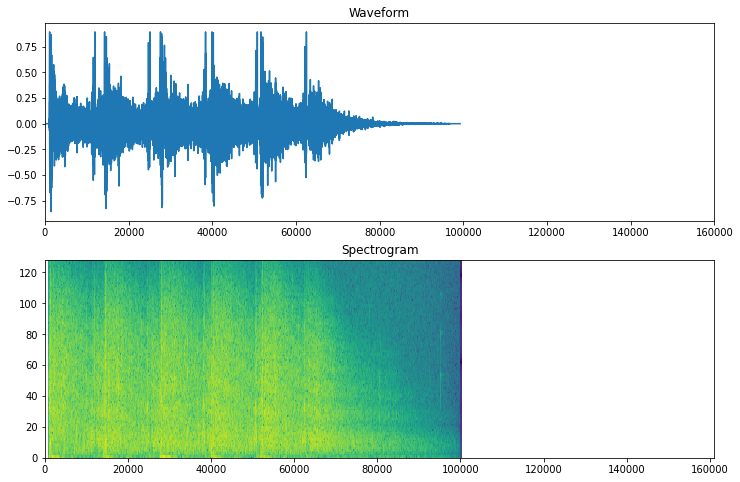

In [29]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

In [ ]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(wf.shape[0])
axes[0].plot(timescale, wf.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 160000])
plot_spectrogram(get_spectrogram(wf).numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [107]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == classes)
  return spectrogram, label_id

In [108]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

In [109]:
batch_size = 64
train_ds = spectrogram_ds.cache().prefetch(AUTOTUNE)

In [110]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(classes)

NotFoundError: RIFFDb

In [ ]:
model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()